In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import netCDF4
import statsmodels.tsa.stattools as tools
import scipy
import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from dateutil import rrule
from datetime import datetime, timedelta
import pandas as pd
pd.set_option('max_rows', 6)  # max number of rows to show in this notebook — to save space!
import seaborn as sns  # for better style in plots
from eofs.standard import Eof
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import xarray as xr

In [2]:
def read_sst_data(dataset_str):
    '''Read SST data from NetCDF file. Four dataset options are available:
       COBE SSTs (use 'cobe')
       ERSST v5 (use 'ersst_v5')
       HadISSTs (use 'hadisst')
       Kaplan SSTs (use 'kaplan')'''
    
    ref_year = {'cobe'     : 1891,
                'ersst_v5' : 1800,
                'hadisst'  : 1870,
                'kaplan'   : 1800}
    
    offset_month = {'cobe'     : -6,
                    'ersst_v5' : -6,
                    'hadisst'  : -4,
                    'kaplan'   : -6}
    
    if (dataset_str == 'kaplan'):
        file = '/data/um/sst/' + dataset_str + '_sst_mon_anom.nc'
    else:
        file = '/data/um/sst/' + dataset_str + '_sst_mon_mean.nc'
        
    nc = netCDF4.Dataset(file)
    
    if (dataset_str == 'hadisst') or (dataset_str == 'cobe'):    
        var_dt = np.array(datetime(ref_year[dataset_str],1,1))
        
        for i in np.arange(nc['time'][:offset_month[dataset_str]].shape[0]):
            buffer_dt = datetime(ref_year[dataset_str],1,1) + timedelta(seconds=nc['time'][:][i]*86400)
            buffer_dt = datetime(buffer_dt.year, buffer_dt.month, 1)                                                            
            var_dt = np.append(var_dt, buffer_dt)
                
        var_dt = var_dt[1:]
        time   = var_dt
    else:
        time = netCDF4.num2date(nc['time'][:offset_month[dataset_str]], nc['time'].units)
     
    if (dataset_str == 'hadisst'):
        cond       = nc['sst'][:offset_month[dataset_str]] == -1000.0
        hadisst_ma = np.ma.masked_where(cond, nc['sst'][:offset_month[dataset_str]])
        return time, nc['longitude'][:], nc['latitude'][:], hadisst_ma
    else:
        return time, nc['lon'][:], nc['lat'][:], nc['sst'][:offset_month[dataset_str]]
    

In [3]:
cobe_time,     cobe_lon,     cobe_lat,     cobe_sst     =     read_sst_data('cobe')
ersst_v5_time, ersst_v5_lon, ersst_v5_lat, ersst_v5_sst = read_sst_data('ersst_v5')
hadisst_time,  hadisst_lon,  hadisst_lat,  hadisst_sst  =  read_sst_data('hadisst')
kaplan_time,   kaplan_lon,   kaplan_lat,   kaplan_sst   =   read_sst_data('kaplan')


In [7]:
cobe_sst_gm     = np.ma.average(np.ma.average(cobe_sst, axis=1, weights=np.cos(np.deg2rad(cobe_lat))), axis=1)
ersst_v5_sst_gm = np.ma.average(np.ma.average(ersst_v5_sst, axis=1, weights=np.cos(np.deg2rad(ersst_v5_lat))), axis=1)
hadisst_sst_gm  = np.ma.average(np.ma.average(hadisst_sst, axis=1, weights=np.cos(np.deg2rad(hadisst_lat))), axis=1)
kaplan_sst_gm   = np.ma.average(np.ma.average(kaplan_sst, axis=1, weights=np.cos(np.deg2rad(kaplan_lat))), axis=1)

cobe_lin_fit     = np.polyfit(np.arange(cobe_sst_gm.shape[0]), cobe_sst_gm, deg=1)
ersst_v5_lin_fit = np.polyfit(np.arange(ersst_v5_sst_gm.shape[0]), ersst_v5_sst_gm, deg=1)
hadisst_lin_fit  = np.polyfit(np.arange(hadisst_sst_gm.shape[0]), hadisst_sst_gm, deg=1)
kaplan_lin_fit   = np.polyfit(np.arange(kaplan_sst_gm.shape[0]), kaplan_sst_gm, deg=1)

cobe_sst_gm_dt     = cobe_sst_gm     -     cobe_lin_fit[0]*np.arange(    cobe_sst_gm.shape[0])
ersst_v5_sst_gm_dt = ersst_v5_sst_gm - ersst_v5_lin_fit[0]*np.arange(ersst_v5_sst_gm.shape[0])
hadisst_sst_gm_dt  = hadisst_sst_gm  -  hadisst_lin_fit[0]*np.arange( hadisst_sst_gm.shape[0])
kaplan_sst_gm_dt   = kaplan_sst_gm   -   kaplan_lin_fit[0]*np.arange(  kaplan_sst_gm.shape[0])

#remove global mean SST time series from each grid point
cobe_sst_gmdt = np.zeros(cobe_sst.shape)
for i in np.arange(cobe_sst.shape[1]):
    for j in np.arange(cobe_sst.shape[2]):
        cobe_sst_gmdt[:,i,j] = cobe_sst[:,i,j] - cobe_sst_gm
cobe_sst_gmdt = np.ma.masked_where(cobe_sst.mask, cobe_sst_gmdt)
        
ersst_v5_sst_gmdt = np.zeros(ersst_v5_sst.shape)
for i in np.arange(ersst_v5_sst.shape[1]):
    for j in np.arange(ersst_v5_sst.shape[2]):
        ersst_v5_sst_gmdt[:,i,j] = ersst_v5_sst[:,i,j] - ersst_v5_sst_gm
ersst_v5_sst_gmdt = np.ma.masked_where(ersst_v5_sst.mask, ersst_v5_sst_gmdt)

hadisst_sst_gmdt = np.zeros(hadisst_sst.shape)
for i in np.arange(hadisst_sst.shape[1]):
    for j in np.arange(hadisst_sst.shape[2]):
        hadisst_sst_gmdt[:,i,j] = hadisst_sst[:,i,j] - hadisst_sst_gm
hadisst_sst_gmdt = np.ma.masked_where(hadisst_sst.mask, hadisst_sst_gmdt)

kaplan_sst_gmdt = np.zeros(kaplan_sst.shape)
for i in np.arange(kaplan_sst.shape[1]):
    for j in np.arange(kaplan_sst.shape[2]):
        kaplan_sst_gmdt[:,i,j] = kaplan_sst[:,i,j] - kaplan_sst_gm
kaplan_sst_gmdt = np.ma.masked_where(kaplan_sst.mask, kaplan_sst_gmdt)

cobe_sst_gmdt_gm     = np.ma.average(np.ma.average(cobe_sst_gmdt,     axis=1, weights=np.cos(np.deg2rad(cobe_lat))),     axis=1)
ersst_v5_sst_gmdt_gm = np.ma.average(np.ma.average(ersst_v5_sst_gmdt, axis=1, weights=np.cos(np.deg2rad(ersst_v5_lat))), axis=1)
hadisst_sst_gmdt_gm  = np.ma.average(np.ma.average(hadisst_sst_gmdt,  axis=1, weights=np.cos(np.deg2rad(hadisst_lat))),  axis=1)
kaplan_sst_gmdt_gm   = np.ma.average(np.ma.average(kaplan_sst_gmdt,   axis=1, weights=np.cos(np.deg2rad(kaplan_lat))),   axis=1)

cobe_df     = pd.DataFrame(data =     cobe_sst_gm, index =     cobe_time, columns = ['raw'])
ersst_v5_df = pd.DataFrame(data = ersst_v5_sst_gm, index = ersst_v5_time, columns = ['raw'])
hadisst_df  = pd.DataFrame(data =  hadisst_sst_gm, index =  hadisst_time, columns = ['raw'])
kaplan_df   = pd.DataFrame(data =   kaplan_sst_gm, index =   kaplan_time, columns = ['raw'])

cobe_df['dt']     = cobe_sst_gm_dt
ersst_v5_df['dt'] = ersst_v5_sst_gm_dt
hadisst_df['dt']  = hadisst_sst_gm_dt
kaplan_df['dt']   = kaplan_sst_gm_dt

cobe_avg_sc     =     cobe_df['dt'].groupby(    cobe_df.index.month).mean()
ersst_v5_avg_sc = ersst_v5_df['dt'].groupby(ersst_v5_df.index.month).mean()
hadisst_avg_sc  =  hadisst_df['dt'].groupby( hadisst_df.index.month).mean()
kaplan_avg_sc   =   kaplan_df['dt'].groupby(  kaplan_df.index.month).mean()

avg_scs = [cobe_avg_sc, ersst_v5_avg_sc, hadisst_avg_sc, kaplan_avg_sc]
dfs     = [cobe_df,     ersst_v5_df,     hadisst_df,     kaplan_df]

for avg_sc, df in zip(avg_scs, dfs):
    tile_avg_sc = np.tile(avg_sc, int(df.shape[0]/12))
    df['no_sc']    = df['raw'].data[:] - tile_avg_sc
    df['dt_no_sc'] = df['dt'].data[:]  - tile_avg_sc

In [8]:
#compute area average
hadisst_nino34_area = hadisst_sst[:,85:95,10:60]
hadisst_nino34_am   = np.ma.average(hadisst_nino34_area,axis=(1,2))
#save to pandas DataFrame
hadisst_nino34 = pd.DataFrame(data = hadisst_nino34_am, index = hadisst_time, columns = ['raw'])
#linearly detrend time series
hadisst_nino34_lin_fit = np.polyfit(np.arange(hadisst_nino34['raw'].shape[0]), hadisst_nino34_am, deg=1)
hadisst_nino34['dt']   = hadisst_nino34_am - hadisst_nino34_lin_fit[0]*np.arange(hadisst_nino34['raw'].shape[0])
#detrend time series by subtracting global mean from each point in area
hadisst_nino34_area_gmdt = hadisst_sst_gmdt[:,85:95,10:60]
hadisst_nino34_am_gmdt   = np.ma.average(hadisst_nino34_area_gmdt,axis=(1,2))
hadisst_nino34['gmdt']   = hadisst_nino34_am_gmdt
#remove seasonal cycle
hadisst_nino34_avg_sc           = hadisst_nino34['raw'].groupby(hadisst_nino34.index.month).mean()
tile_hadisst_nino34_avg_sc      = np.tile(hadisst_nino34_avg_sc, int(hadisst_nino34['raw'].shape[0]/12))
hadisst_nino34['dt_no_sc']      = hadisst_nino34['dt'].data[:]  - tile_hadisst_nino34_avg_sc
hadisst_nino34_avg_sc_gmdt      = hadisst_nino34['gmdt'].groupby(hadisst_nino34.index.month).mean()
tile_hadisst_nino34_avg_sc_gmdt = np.tile(hadisst_nino34_avg_sc_gmdt, int(hadisst_nino34['gmdt'].shape[0]/12))
hadisst_nino34['gmdt_no_sc']    = hadisst_nino34['gmdt'].data[:] - tile_hadisst_nino34_avg_sc_gmdt
#smooth with 5-month centered running mean
hadisst_nino34['dt_no_sc_smooth']   = hadisst_nino34['dt_no_sc'].rolling(5,center=True).mean()
hadisst_nino34['gmdt_no_sc_smooth'] = hadisst_nino34['gmdt_no_sc'].rolling(5,center=True).mean()
#normalize by standard deviation
hadisst_nino34['dt_no_sc_smooth_norm']   = hadisst_nino34['dt_no_sc_smooth']/np.std(hadisst_nino34['dt'])
hadisst_nino34['gmdt_no_sc_smooth_norm'] = hadisst_nino34['gmdt_no_sc_smooth']/np.std(hadisst_nino34['gmdt'])


In [9]:
#compute area average
hadisst_anom     = hadisst_sst.anom(axis=0)
hadisst_amo_area = hadisst_anom[:,10:90,100:180]
hadisst_amo_am   = np.ma.average(np.ma.average(hadisst_amo_area, axis=1, weights=np.cos(np.deg2rad(hadisst_lat[10:90]))), axis=1)
#save to pandas DataFrame
hadisst_amo = pd.DataFrame(data = hadisst_amo_am, index = hadisst_time, columns = ['raw'])
#linearly detrend time series
hadisst_amo_lin_fit = np.polyfit(np.arange(hadisst_amo['raw'].shape[0]), hadisst_amo_am, deg=1)
hadisst_amo['dt']   = hadisst_amo_am - hadisst_amo_lin_fit[0]*np.arange(hadisst_amo['raw'].shape[0])
#detrend time series by subtracting global mean time series
hadisst_amo['gmdt'] = hadisst_amo_am - np.ma.average(hadisst_anom, axis=(1,2))
#remove seasonal cycle
hadisst_amo_avg_sc           = hadisst_amo['dt'].groupby(hadisst_amo.index.month).mean()
tile_hadisst_amo_avg_sc      = np.tile(hadisst_amo_avg_sc, int(hadisst_amo['raw'].shape[0]/12))
hadisst_amo['dt_no_sc']      = hadisst_amo['dt'].data[:]  - tile_hadisst_amo_avg_sc
hadisst_amo_avg_sc_gmdt      = hadisst_amo['gmdt'].groupby(hadisst_amo.index.month).mean()
tile_hadisst_amo_avg_sc_gmdt = np.tile(hadisst_amo_avg_sc_gmdt, int(hadisst_amo['raw'].shape[0]/12))
hadisst_amo['gmdt_no_sc']    = hadisst_amo['gmdt'].data[:]  - tile_hadisst_amo_avg_sc_gmdt
#smooth with 120-month centered running mean
hadisst_amo['dt_no_sc_smooth']   =   hadisst_amo['dt_no_sc'].rolling(120, center=True, win_type='triang').mean()
hadisst_amo['gmdt_no_sc_smooth'] = hadisst_amo['gmdt_no_sc'].rolling(120, center=True, win_type='triang').mean()


In [52]:
#hadisst centered on dateline, therefore cutoff; must roll lon axis for proper calculation
hadisst_sst_roll = np.roll(hadisst_sst, 180, axis=2)
hadisst_lon_roll = np.roll(hadisst_lon, 180)
hadisst_lon_roll[np.where(hadisst_lon_roll < 0)] = hadisst_lon_roll[np.where(hadisst_lon_roll < 0)] + 360
#isolate PDO area
hadisst_pdo_area = hadisst_sst_roll[:,20:70,120:260]
#remove climatological annual cycle at each gridpoint
hadisst_pdo_no_sc    = np.zeros(hadisst_pdo_area.shape)
hadisst_pdo_no_sc_dt = np.zeros(hadisst_pdo_area.shape)
for i in np.arange(hadisst_pdo_area.shape[1]):
    for j in np.arange(hadisst_pdo_area.shape[2]):
        buffer = pd.DataFrame(data=hadisst_pdo_area[:,i,j], index=hadisst_time)
        gridpoint_avg_sc = buffer.groupby(buffer.index.month).mean()      
        tile_gridpoint_avg_sc = np.tile(gridpoint_avg_sc.T, int(hadisst_pdo_area.shape[0]/12))
        hadisst_pdo_no_sc[:,i,j] = hadisst_pdo_area[:,i,j] - tile_gridpoint_avg_sc
        #remove global mean anomaly from gridpoint
        hadisst_pdo_no_sc_dt[:,i,j] = hadisst_pdo_no_sc[:,i,j] - hadisst_sst_gm.anom()
#calculate leading PC for PDO area
hadisst_pdo_no_sc_dt = np.ma.masked_where(hadisst_sst_roll[:,20:70,120:260].mask, hadisst_pdo_no_sc_dt)
solver               = Eof(hadisst_pdo_no_sc_dt, weights=np.cos(np.deg2rad(hadisst_lat[20:70]))[...,np.newaxis])
hadisst_pdo_eof      = -solver.eofs(neofs=10)
hadisst_pdo          = pd.DataFrame(data=-solver.pcs(npcs=1, pcscaling=0), index=hadisst_time, columns=['pc'])
#normalize
hadisst_pdo['pc_norm'] = hadisst_pdo['pc']/np.std(hadisst_pdo['pc'])
#smooth with 10-year running mean
hadisst_pdo['pc_norm_smooth'] = hadisst_pdo['pc_norm'].rolling(120, center=True, win_type='triang').mean()


In [27]:
climo_ind               = pd.DataFrame(data=hadisst_nino34['dt_no_sc_smooth_norm']['1900':'2010'].values, index=hadisst_nino34['dt_no_sc_smooth_norm']['1900':'2010'].index, columns=['nino34'])
climo_ind['pdo_smooth'] = hadisst_pdo['pc_norm_smooth']['1900':'2010']
climo_ind['amo_smooth'] = hadisst_amo['dt_no_sc_smooth']['1900':'2010']
climo_ind['pdo']        = hadisst_pdo['pc_norm']['1900':'2010']
climo_ind['amo']        = hadisst_amo['dt_no_sc']['1900':'2010']

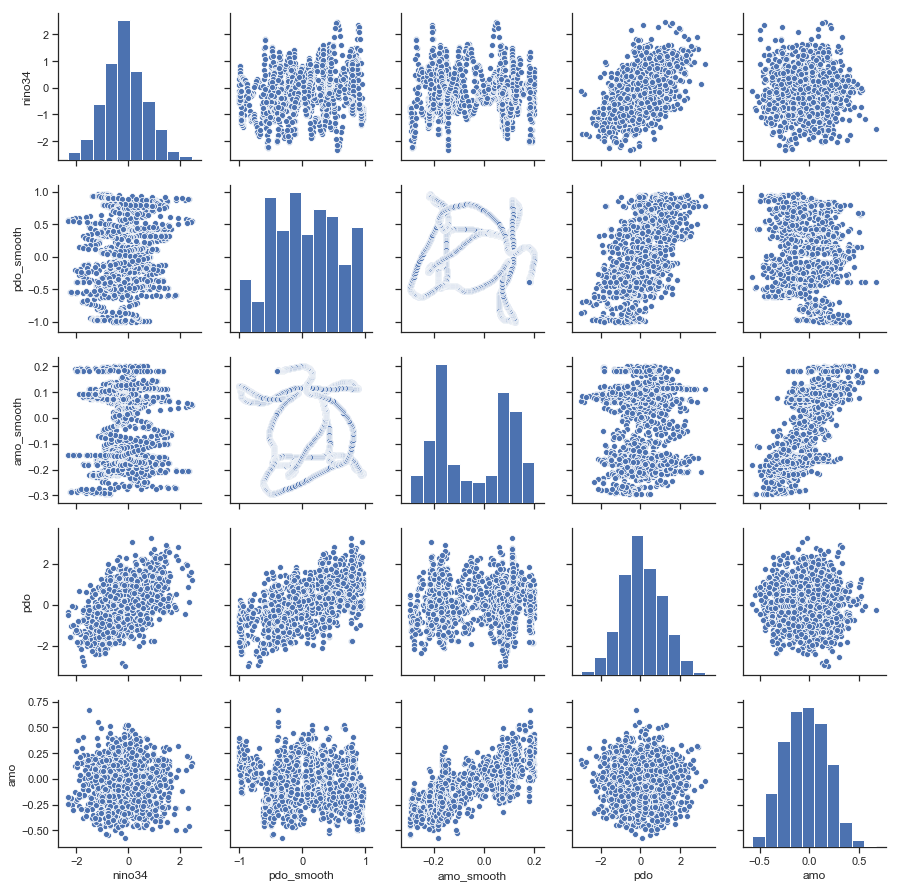

In [28]:
sns.set(style="ticks")
sns.pairplot(climo_ind)

In [47]:
def heatmap(x, y, size):
    fig, ax = plt.subplots(figsize=(8,8))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 3000
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])


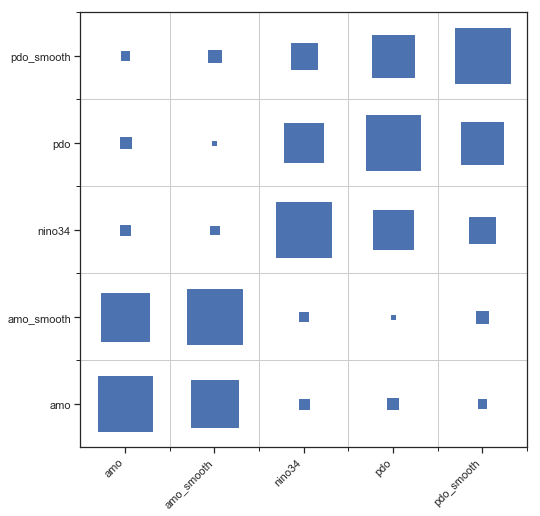

In [48]:
col = ['nino34', 'pdo_smooth', 'amo_smooth', 'pdo', 'amo'] 
corr = climo_ind[col].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(x=corr['x'], y=corr['y'], size=corr['value'].abs())

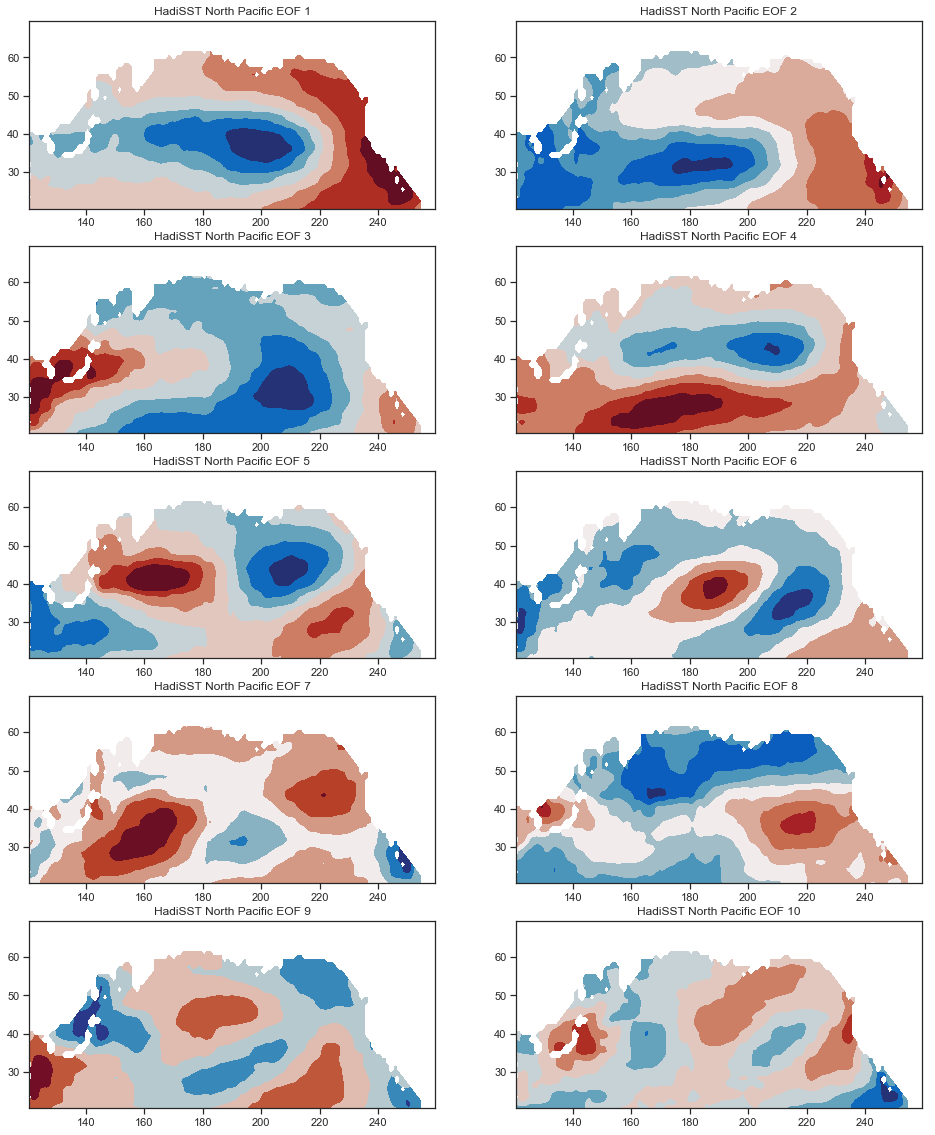

In [67]:
fig = plt.figure(figsize=(16,20))

for i in np.arange(10):
    ax = fig.add_subplot(5,2,i+1)
    ax.contourf(hadisst_lon_roll[120:260], hadisst_lat[20:70], hadisst_pdo_eof[i,:,:], cmap=cmo.balance)
    ax.set_title('HadiSST North Pacific EOF ' + str(i+1))


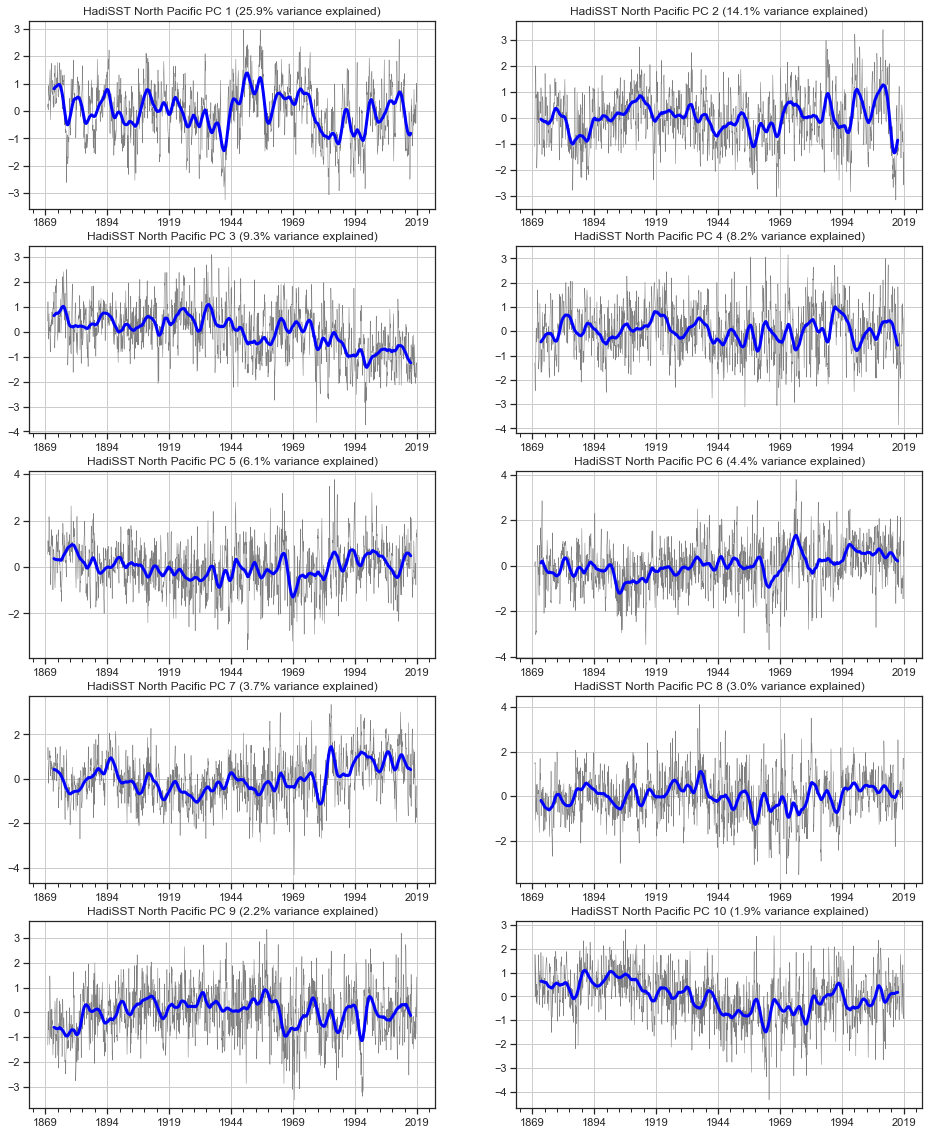

In [72]:
fig = plt.figure(figsize=(16,20))
hadisst_npac_pcs  = solver.pcs(npcs=10, pcscaling=0)
hadisst_npac_vars = solver.varianceFraction()

for i in np.arange(10):
    ax = fig.add_subplot(5,2,i+1)
    npac_pc = pd.DataFrame(data=hadisst_npac_pcs[:,i], index=hadisst_time, columns=['pc'])
    npac_pc['pc'] = npac_pc['pc']/np.std(npac_pc['pc'])
    npac_pc['pc'].plot(ax=ax,linewidth=.5,color='grey')
    npac_pc['pc'].rolling(60,win_type='triang',center=True).mean().plot(ax=ax,linewidth=3,color='blue')
    ax.set_title('HadiSST North Pacific PC ' + str(i+1) + ' (' + str(round(hadisst_npac_vars[i]*1000)/10) + '% variance explained)')
    ax.grid()
